In this tutorial, we would like to implement VALMOD algorithm proposed in paper [VALMOD](https://arxiv.org/pdf/2008.13447.pdf), and reproduce its results as closely as possible.

The **VAriable Length MOtif Discovery (VALMOD)** algorithm takes time series `T` and a range of subsequence length `[min_m, max_m]`, and find motifs and discords.

In [1]:
%matplotlib inline

import stumpy
from stumpy import core, config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

# 1- Introduction

**Notation:** $T_{i,m} = T[i:i+m]$, a subsequence of `T` that starts at index `i` and has length `m` 

### Motif discovery

For a given motif pair $\{T_{idx,m},T_{nn\_idx,n}\}$, Motif set $S^{m}_{r}$ is a set of subsequences of length `m` that has `distance < r` to either $T_{idx,m}$ or $T_{nn\_idx,n}$. And, the cardinality of set is called the frequency of the motif set.

We would like to find set $S^{*} = \bigcup\limits_{m=min\_m}^{max\_m}{S^{m}_{r}}$, and $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$. In other words, we want to find motif sets for different length `m` and we want to make sure there is no "common" (see note below) subsequence between any two motif sets. 

**NOTE:** The subsequences in motif set of length m and m' are indeed different because they have different length. However, by the constraint $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$, the authors meant to avoid considering two subsequences (of different length) that start from the same index. For instance, if $T_{200,m}$ is in one set and $T_{200,m'}$ in another set, the authors consider the intersection of their corresponding set to be non-empty because both these two subsequences start from the same index.

### Discord discovery

First, we need to provide a few definitions...

**$n^{th}$ best match**: For the subsequence $T_{i,m}$, its $n^{th}$ best match is simply the $n^{th}$ smallest distance in the distance profile. <br>

**$n^{th}$ discord**: a subsequence $T_{i,m}$ is the $n^{th}$ discord  if it has the largest value to its $n^{th}$ best match compared to the distances between any other subsequence and its ($n^{th}$ ?) best match. <br>

**NOTE**:<br>
Why should I care about $n^{th}$ discord (n>1)? We provide a simple example below:

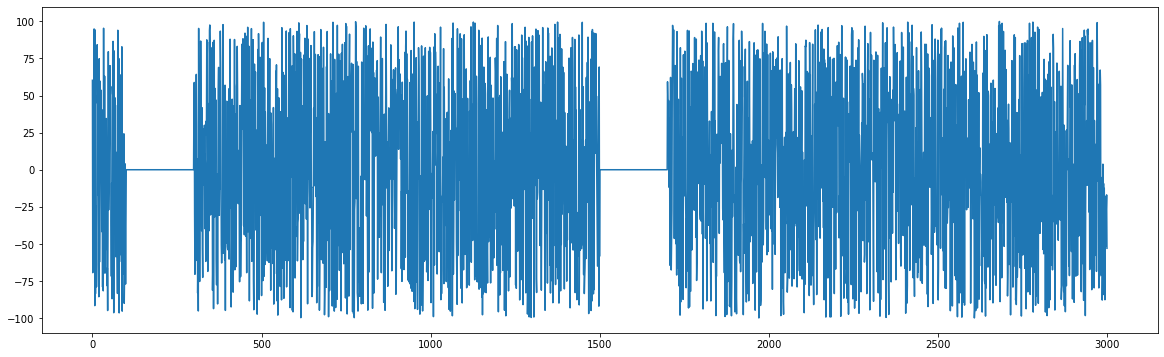

In [2]:
T = np.random.uniform(-100,100,size=3000)
m = 200
i, j = 100, 1500

T[i:i+m] = 0
T[j:j+m] = 0

plt.plot(T)
plt.show()

Here, the subsequences at index `i` and `j` can be considered an anomaly. However, the 1NN distance is 0 for them. Therefore, we may need to investigate other neighbors rather than just 1NN. In discord discovery, it is called twin-freak problem (see [Tutorial](https://cci.drexel.edu/bigdata/bigdata2017/files/Tutorial4.pdf)). It happens when the (same) anomally occurs more than once. In our example above, the anomaly occurs twice. Therefore, we should be able to detect it if we consider 2nd nearest neighbor. 

For further details, see Fig. 2 of the paper. Notice that `Top-1 2nd discord` subsequence has a close 1-NN; however, it is far from its 2nd closest neighbor.)

**Variable-length Top-k $n^{th}$ Discord Discovery:** <br>
Given a time series `T`, a subsequence length-range `[min_m, max_m]`,`K`, and `N`, we want to find **top-k $n^{th}$ discord** for each `k` in $\{1,...,K\}$, for each `n` in $\{1,...,N\}$, and for all `m` in $\{min\_m,...,max\_m\}$.

# 2- Lower-Bound Distance Profile

The idea goes as follows: "given the distance profile of $T_{j,m}$, how can we find a lower bound for distance profile of $T_{j,m+k}$", where $T_{j,m+k}$ represents a sequence that starts from the same index `j` with length `m+k`?

In other words, can we find **Lower Bound (LB)** for $d(T_{j,m+k}, T_{i,m+k})$ only by help of $T_{j,m}$, $T_{i,m}$, and $T_{j,m+k}$? (So, the last `k` elements of $T_{i,m+k}$ are unknown)

## 2-1 Non-normalized distance


$$
\begin{align}
    d^{(m+k)}_{j,i} ={}& 
        \sqrt[\leftroot{5}\uproot{5}p]{
                \sum\limits_{t=1}^{m+k}{
                \bigg\lvert{
                 T[i+t-1] - T[j+t-1]
                 }\bigg\rvert
                }^{p}
                }
    \\
    ={}&
    \sqrt[\leftroot{5}\uproot{5}p]{
        \sum\limits_{t=1}^{m}{
            \bigg\lvert{
            T[i+t-1] - T[j+t-1]
            }\bigg\rvert
         }^{p}
         +
         \sum\limits_{t=m+1}^{m+k}{
            \bigg\lvert{
            T[i+t-1] - T[j+t-1]
            }\bigg\rvert
         }^{p}
      }
    \\
    \geq{}&
    \sqrt[\leftroot{5}\uproot{5}p]{
        \sum\limits_{t=1}^{m}{
            \bigg\lvert{
            T[i+t-1] - T[j+t-1]
            }\bigg\rvert
         }^{p}
      }
    \\
\end{align}
$$


Therefore:


$$
\begin{align}
    d^{(m+k)}_{j,i} \geq{}&
    d^{(m)}_{j,i}
\end{align}
$$


In other words, we can simply use the p-norm distance between $T_{i,m}$ and $T_{j,m}$ as the lower-bound value for the distance between $T_{i,m+k}$ and $T_{j,m+k}$.

## 2-2 Normalized distance

In z-normalized distance, one should note that $d^{(m+k)}_{j,i} \geq d^{(m)}_{j,i}$ is not necessarily correct. In other words, the distance between two subsequences does not necessarily increase by making them longer. However, it seems there is a very nice relationship between $d_{j,i}^{(m)}$ and the lower-bound value of $d_{j,i}^{(m+k)}$.

### Derving Equation (2)


$$
\begin{align}
    d^{(m+k)}_{j,i} ={}& 
        \sqrt{\sum\limits_{t=1}^{m+k}{{
        \left(\frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{i,m+k}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m+k}}\right)
        }^{2}}} 
    \\
    d^{(m+k)}_{j,i} ={}& 
        \sqrt{
        \sum\limits_{t=1}^{m}{{
        \left(\frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{i,m+k}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m+k}}\right)
        }^{2}}
        +
        \sum\limits_{t=m+1}^{m+k}{{
        \left(\frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{i,m+k}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m+k}}\right)
        }^{2}}
        } 
    \\
    \geq{}&
        \sqrt{\sum\limits_{t=1}^{m}{{
        \left(\frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{i,m+k}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m+k}}\right)
        }^{2}}}
    \\
\end{align}
$$


So, the Lower-Bound (LB) value for $d_{j,i}^{(m+k)}$ can be obtained by minimizing the right-hand side:


$$
\begin{align}
    LB ={}& 
        \min \sqrt{\sum\limits_{t=1}^{m}{{
        \left(\frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{i,m+k}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m+k}}\right)
        }^{2}}} 
    \\
    ={}&
    \min \sqrt{\sum\limits_{t=1}^{m}{{
        \left[\frac{1}{\sigma_{j,m+k}}
            \left(
            \frac{T[i+t-1] - \mu_{i,m+k}}{\frac{\sigma_{i,m+k}}{\sigma_{j,m+k}}} - \frac{T[j+t-1] - \mu_{j,m+k}}{1}
            \right)
        \right]
        }^{2}}}
    \\
    ={}&
    \min \sqrt{
        \sum\limits_{t=1}^{m}{{
            \left[
                \frac{\sigma_{j,m}}{\sigma_{j,m}}
                \frac{1}{\sigma_{j,m+k}}
                \left(
                     \frac{T[i+t-1] - \mu_{i,m+k}}{\frac{\sigma_{i,m+k}}{\sigma_{j,m+k}}} 
                     - 
                     \frac{T[j+t-1] - \mu_{j,m+k}}{1}
                 \right)
            \right]
                }^{2}
        }
        }
    \\
    ={}&
    \min \sqrt{
        \sum\limits_{t=1}^{m}{{
            \left[
                \frac{\sigma_{j,m}}{\sigma_{j,m+k}}
                \left(
                     \frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{j,m}\frac{\sigma_{i,m+k}}{\sigma_{j,m+k}}} 
                     - 
                     \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}
                 \right)
            \right]
                }^{2}
        }
        }
    \\
    ={}&
    \frac{\sigma_{j,m}}{\sigma_{j,m+k}} \times \min \sqrt{\sum\limits_{t=1}^{m}{\left(\frac{T[i+t-1] - \mu_{i,m+k}}{\frac{\sigma_{j,m} \sigma_{i,m+k}}{\sigma_{j,m+k}}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}\right)^{2}}}
    \\
\end{align}
$$


**Note:** that the variables are $\mu_{i,m+k}$ and $\sigma_{i,m+k}$. Also, note that all $\mu$ and $\sigma$ values are **constant** regardless of them being known or unknown. <br>

We subtitute $\mu_{i,m+k}$ with $\mu^{'}$, and $\frac{\sigma_{j,m} \sigma_{i,m+k}}{\sigma_{j,m+k}}$ with $\sigma^{'}$.


$$
\begin{align}
    LB ={}& 
        \frac{\sigma_{j,m}}{\sigma_{j,m+k}}
        \sqrt{f(\mu^{'},\sigma^{'})} \quad (1)
    \\
    f(\mu^{'}, \sigma^{'}) ={}& 
        \sum\limits_{t=1}^{m}{{
        \left(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}\right)
        }^{2}} \quad (2)
    \\
\end{align}
$$



$$
\begin{align}
    \alpha_{t} \triangleq{}& 
        {
        \frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}} \quad (3)
        } 
    \\
\end{align}
$$


Therefore, we can write $f(\mu_{'},\sigma_{'})$ as follows:


$$
\begin{align}
    f(\mu^{'}, \sigma^{'}) ={}& 
    \sum \limits_{t=1}^{m} {\alpha_t^{2}} \quad (4)
    \\
\end{align}
$$


Please note that the unknown variables are now $\mu^{'}$ and $\sigma^{'}$. <br>
**To find extrema points, we first need to find the critical point(s) by solving the single system of equations below.**  In other words, we are looking for $\mu^{'}$ and $\sigma^{'}$ that satisfies both equations below.




$$
\begin{align}
    \frac{\partial{f}}{\partial{\mu^{'}}} = 0 \quad (5)
    \\
    \frac{\partial{f}}{\partial{\sigma^{'}}} = 0 \quad (6)
    \\
\end{align}
$$


**Deriving $\frac{\partial{f}}{\partial{\mu^{'}}}$:**


$$
\begin{align}
    \frac{\partial{f}}{\partial{\mu^{'}}} ={}& 
    \sum \limits_{t=1}^{m}{
        \frac{\partial{(\alpha_{t}^{2})}}{\partial{\mu^{'}}}
    }
    \\
    \frac{\partial{f}}{\partial{\mu^{'}}} ={}& 
    \sum \limits_{t=1}^{m}{
        2\frac{\partial{(\alpha_{t})}}{\partial{\mu^{'}}}\alpha_{t}
    }
    \\
    \frac{\partial{f}}{\partial{\mu^{'}}} ={}&
    \sum \limits_{t=1}^{m} {
    2\left(
    \frac{-1}{\sigma^{'}}
    \right)
    \alpha_{t}} 
    \\
    0 ={}&
    \frac{-2}{\sigma^{'}}\sum \limits_{t=1}^{m}{\alpha_{t}}
    \\
\end{align}
$$


Please note that $\sigma^{'}$ is constant and thus it was factered out of the summation. <br>
This gives us:


$$
\begin{align}
    \sum \limits_{t=1}^{m}{\alpha_{t}} = 0 \quad (7)
\end{align}
$$


**Exapanding (7):**


$$
\begin{align}
    \sum \limits_{t=1}^{m} \alpha_{t} ={}& 
    0
    \\
    \sum \limits_{t=1}^{m} {\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}} ={}& 
    0
    \\
    \frac{1}{\sigma^{'}}\left(\sum \limits_{t=1}^{m}T[i+t-1] - \sum \limits_{t=1}^{m} \mu^{'}\right) - 
    \frac{1}{\sigma_{j,m}}\left(\sum \limits_{t=1}^{m}T[j+t-1] - \sum \limits_{t=1}^{m} \mu_{j,m+k}\right) ={}& 
    0
    \\
    \frac{1}{\sigma^{'}}\left(m\mu_{i,m} - m\mu^{'}\right) - 
    \frac{1}{\sigma_{j,m}}\left(m\mu_{j,m} - m\mu_{j,m+k}\right) ={}& 
    0
    \\
    \sigma_{j,m}\left(\mu_{i,m} - \mu^{'}\right) - 
    \sigma^{'}\left(\mu_{j,m} - \mu_{j,m+k}\right) ={}& 
    0
    \\
    \sigma_{j,m} \mu^{'} + 
    \left(\mu_{j,m} - \mu_{j,m+k}\right)\sigma^{'} - \sigma_{j,m}\mu_{i,m} ={}& 
    0 \quad (8)
\end{align} 
$$


**Deriving $\frac{\partial{f}}{\partial{\sigma^{'}}}$:**


$$
\begin{align}
    \frac{\partial{f}}{\partial{\sigma^{'}}} ={}& 
    \sum \limits_{t=1}^{m}{
        \frac{\partial{(\alpha_{t}^{2})}}{\partial{\sigma^{'}}}
    }
    \\
    \frac{\partial{f}}{\partial{\sigma^{'}}} ={}& 
    \sum \limits_{t=1}^{m}{
        2\frac{\partial{(\alpha_{t})}}{\partial{\sigma^{'}}}\alpha_{t}
    }
    \\
    \frac{\partial{f}}{\partial{\sigma^{'}}} ={}&
    \sum \limits_{t=1}^{m} {
    2 \left(
        \frac{-\left({T[i+t-1] - \mu^{'}}\right)}{\sigma^{'2}}
    \right)
    \alpha_{t}} 
    \\
    \frac{\partial{f}}{\partial{\sigma^{'}}} ={}&
    \frac{-2}{\sigma^{'2}}\sum \limits_{t=1}^{m}{\left({T[i+t-1] - \mu^{'}}\right) \alpha_{t}}
    \\
    \frac{\partial{f}}{\partial{\sigma^{'}}} ={}&
    \frac{-2}{\sigma^{'2}}\sum \limits_{t=1}^{m}{\left({T[i+t-1]\alpha_{t} - \mu^{'}\alpha_{t}}\right)}
    \\
    \frac{\partial{f}}{\partial{\sigma^{'}}} ={}&
    \frac{-2}{\sigma^{'2}}
    {\left(
    \sum \limits_{t=1}^{m}{T[i+t-1]\alpha_{t}} 
    - 
    \sum \limits_{t=1}^{m}{\mu^{'}\alpha_{t}}
    \right)
    }
    \\
    \frac{\partial{f}}{\partial{\sigma^{'}}} ={}&
    \frac{-2}{\sigma^{'2}}
    {\left(
    \sum \limits_{t=1}^{m}{T[i+t-1]\alpha_{t}} 
    - 
    \mu^{'}\sum \limits_{t=1}^{m}{\alpha_{t}}
    \right)
    }
    \\
    0 ={}&
    \frac{-2}{\sigma^{'2}}
    {\left(
    \sum \limits_{t=1}^{m}{T[i+t-1]\alpha_{t}} 
    - 
    \mu^{'}\cdot 0
    \right)
    }
    \\
    0 ={}&
    \frac{-2}{\sigma^{'2}}
    {
    \sum \limits_{t=1}^{m}{T[i+t-1]\alpha_{t}} 
    }
\end{align}
$$


And, this gives:


$$
\begin{align}
    \sum \limits_{t=1}^{m}{T[i+t-1]\alpha_{t}}  ={}&
    0 \quad (9)
\end{align}
$$


**Expanding (9):**


$$
\begin{align}
    \sum \limits_{t=1}^{m} T[i+t-1] \left(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}\right) = 0
    \\
\end{align}
$$



$$
\begin{align}
    \frac{1}{\sigma^{'}}
    \left(
    \sum\limits_{t=1}^{m}T[i+t-1]T[i+t-1]
    -
    \sum\limits_{t=1}^{m}T[i+t-1]\mu^{'}
    \right) 
    - 
    \frac{1}{\sigma_{j,m}}
    \left(
    {\sum\limits_{t=1}^{m}T[i+t-1]T[j+t-1] 
    -\sum \limits_{t=1}^{m}T[i+t-1]\mu_{j,m+k}
    }
    \right) 
    ={}& 0
    \\
    \frac{1}{\sigma^{'}}
    \left(
    \sum \limits_{t=1}^{m}T[i+t-1]T[i+t-1]
    -
    \mu^{'}\sum\limits_{t=1}^{m} T[i+t-1]
    \right) 
    - 
    \frac{1}{\sigma_{j,m}}
    \left(
    \sum\limits_{t=1}^{m}T[i+t-1]T[j+t-1]
    -
    \mu_{j,m+k}\sum \limits_{t=1}^{m}T[i+t-1]
    \right) 
    ={}& 0 \quad (*)
\end{align} 
$$


Now, recall the pearson correlation $\rho$:


$$
\begin{align}
    \rho = \frac{\sum \limits_{t=1}^{m}T[i+t-1]T[j+t-1] - m\mu_{i,m}\mu_{j,m} }{m\sigma_{i,m}\sigma_{j,m}}
    \\
\end{align}
$$


Note: The pearson correlation, $\rho$, is 1 when $i=j$. Becauses, the correlation of any subsequence with itself is 1. <br>
Note: we can rewrite pearson correlation equation as: $\sum \limits_{t=1}^{m}T[i+t-1]T[j+t-1] = m\rho\sigma_{i,m}\sigma_{j,m} + m\mu_{i,m}\mu_{j,m}$ (\*\*)

**Therefore, with help of (\*\*), we continue our calculation from eq(\*):**


$$
\begin{align}
    \frac{1}{\sigma^{'}}
    \left[
    \left(
    m\sigma_{i,m}^{2} + m\mu_{i,m}^{2}
    \right)
    - 
    \mu^{'} \cdot m\mu_{i,m}
    \right] 
    - 
    \frac{1}{\sigma_{j,m}}
    \left[
    \left(
    m\rho\sigma_{i,m}\sigma_{j,m} 
    + 
    m\mu_{i,m}\mu_{j,m}
    \right)
    - 
    \mu_{j,m+k} \cdot m\mu_{i,m}
    \right]
    ={}& 0
    \\
    \frac{1}{\sigma^{'}\sigma_{j,m}}
    \left[
    \sigma_{j,m}\left(
    m\sigma_{i,m}^{2} 
    + 
    m\mu_{i,m}^{2} 
    - 
    \mu^{'} \cdot m\mu_{i,m}
    \right) 
    - 
    \sigma^{'}\left(
    {m\rho\sigma_{i,m}\sigma_{j,m} 
    +
    m\mu_{i,m}\mu_{j,m} 
    -
    \mu_{j,m+k} \cdot m\mu_{i,m}}
    \right)
    \right] ={}& 0
    \\
    \frac{m}{
    \sigma^{'}\sigma_{j,m}
    }
    \left[
    \sigma_{j,m}\left(
    \sigma_{i,m}^{2} 
    + 
    \mu_{i,m}^{2} 
    - 
    \mu^{'} \mu_{i,m}
    \right) 
    - 
    \sigma^{'}\left(
    {\rho\sigma_{i,m}\sigma_{j,m} 
    +
    \mu_{i,m}\mu_{j,m}
    -
    \mu_{j,m+k} \mu_{i,m}}
    \right)
    \right]
    ={}& 0
    \\
    \sigma_{j,m}\left(
    \sigma_{i,m}^{2} 
    + 
    \mu_{i,m}^{2} 
    - 
    \mu^{'} \mu_{i,m}
    \right) 
    - 
    \sigma^{'}\left(
    {\rho\sigma_{i,m}\sigma_{j,m} 
    +
    \mu_{i,m}\mu_{j,m}
    -
    \mu_{j,m+k} \mu_{i,m}}
    \right)
    ={}& 0
    \\
\end{align}
$$



$$
\begin{align}
    \mu_{i,m}\sigma_{j,m}\mu^{'} + (\rho\sigma_{i,m}\sigma_{j,m} + \mu_{i,m}\mu_{j,m} - \mu_{i,m}\mu_{j,m+k})\sigma^{'} - \sigma_{j,m}(\mu_{i,m}^{2} + \sigma_{i,m}^{2}) = 0 \quad (10)
    \\
\end{align}
$$


**Solving (8) and (10) gives the values of critical point:**


$$
\begin{align}
    \mu^{'} = \mu_{i,m} - \frac{\sigma^{i,m}}{\rho\sigma_{j,m}}(\mu_{j,m}-\mu_{j,m+k}) \quad (11)
\end{align}
$$

$$
\begin{align}
    \sigma^{'} = \frac{\sigma_{i,m}}{\rho} \quad (12)
\end{align}
$$

**Note:** Since standard deviation is positive, eq(12) is valid only if $\rho \gt 0$. Therefore, the rest of this calculation is based on the assumption that $\rho \gt 0$. (We will discuss $\rho \leq 0$ later...)

---

Now that we calculated the values $\mu^{'}$ and $\sigma^{'}$ of the crtical point, we need to plug them in $f(.)$ to find the extremum value. However, using these values directly in function $f(.)$ might make the calculation difficult. Therefore, we prefer to use higher-level equations (7) and (9) to first simplify $f_{min}(.)$. Note that we have been solving the single system of equations (5) and (6). Therefore, the calculated values $\mu^{'}$(11) and $\sigma^{'}$(12) should satisfy all  equations (5), (6), (7), (8), (9), and (10) discovered throughout the solution. <br>

**Start with equation (4):**


$$
\begin{align}
    f(\mu^{'}_{c},\sigma^{'}_{c}) ={}&
    \sum \limits_{t=1}^{m}\alpha_{t}^{2}
    \\
    ={}&
    \sum \limits_{t=1}^{m}\alpha_{t} \cdot \alpha_{t}
     \\
\end{align}
$$


And, we replace one of $\alpha_{t}$ with its equivalent term provided in eq(3)...


$$
\begin{align}
    f_{min}(\mu^{'},\sigma^{'}) ={}&
    \sum\limits_{t=1}^{m}{
    {\alpha_{t}
        \left(
        \frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}
        \right)
        }}
    \\
    ={}&
      {
        \frac{1}{\sigma^{'}}
        \left(
        \sum\limits_{t=1}^{m}
        T[i+t-1]\alpha_{t} 
        - 
        \sum\limits_{t=1}^{m}
        \mu^{'}\alpha_{t}
        \right)
        - \frac{1}{\sigma_{j,m}}
        \left(
        \sum\limits_{t=1}^{m}
        T[j+t-1]\alpha_{t} 
        - 
        \sum\limits_{t=1}^{m}
        \mu_{j,m+k}\alpha_{t}
        \right)
     } 
    \\ 
    ={}&
      {
        \frac{1}{\sigma^{'}}
        \left(
        \sum\limits_{t=1}^{m}
        T[i+t-1]\alpha_{t} 
        - 
        \mu^{'}\sum\limits_{t=1}^{m}\alpha_{t}
        \right)
        - 
        \frac{1}{\sigma_{j,m}}
        \left(
        \sum\limits_{t=1}^{m}T[j+t-1]\alpha_{t} 
        - 
        \mu_{j,m+k}\sum\limits_{t=1}^{m}\alpha_{t}
        \right)
     } 
    \\
\end{align}
$$


And, now with help of eq(7), $\sum\limits_{t=1}^{m}{\alpha_{t}}=0$, and the eq(9), $\sum\limits_{t=1}^{m}{T[i+t-1]\alpha_{t}}=0$, we will have:


$$
\begin{align}
    f_{min}(\mu^{'},\sigma^{'}) ={}&
      {
        \frac{1}{\sigma^{'}}
        \left(
        0 - \mu^{'} \cdot 0
        \right) 
        - 
        \frac{1}{\sigma_{j,m}}
        \left(
        \sum\limits_{t=1}^{m}T[j+t-1]\alpha_{t} - \mu_{j,m+k}\cdot 0
        \right)
     } 
    \\ 
    ={}&
      {
         - \frac{1}{\sigma_{j,m}} \sum\limits_{t=1}^{m}T[j+t-1]\alpha_{t}
     } 
    \\
    ={}&
      {
         - \frac{1}{\sigma_{j,m}} 
         \sum\limits_{t=1}^{m}{\left[
         T[j+t-1]\left(
         \frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}
         \right)
         \right]
         }
     } 
    \\
    ={}&
      {
         - \frac{1}{\sigma_{j,m}} 
         \sum\limits_{t=1}^{m}{
         \left(
         \frac{T[i+t-1]T[j+t-1] - \mu^{'}T[j+t-1]}{\sigma^{'}} - \frac{T[j+t-1]T[j+t-1] - \mu_{j,m+k}T[j+t-1]}{\sigma_{j,m}}
         \right)
         }
     } 
    \\
    ={}&
      {- \frac{1}{\sigma_{j,m}} 
         {
         \left(
         \frac{\sum\limits_{t=1}^{m}T[i+t-1]T[j+t-1] - \mu^{'}\sum\limits_{t=1}^{m}T[j+t-1]}{\sigma^{'}} 
         - 
         \frac{\sum\limits_{t=1}^{m}T[j+t-1]T[j+t-1] - \mu_{j,m+k}\sum\limits_{t=1}^{m}T[j+t-1]}{\sigma_{j,m}}
         \right)
         }
     } 
    \\
\end{align}
$$


And, now with help of the fact that $\sum{T} = m\mu$ and also the Pearon Correlation equation (\*\*)...


$$
\begin{align}
    f_{min}(\mu^{'},\sigma^{'}) ={}&  
      {- \frac{1}{\sigma_{j,m}} 
         {
         \left(
         \frac{(m\rho\sigma_{i,m}\sigma_{j,m} + m\mu_{i,m}\mu_{j,m}) - \mu^{'} \cdot m\mu_{j,m}}{\sigma^{'}} 
         - 
         \frac{(m\sigma_{j,m}^{2} + m\mu_{j,m}^{2}) - \mu_{j,m+k} \cdot m\mu_{j,m}}{\sigma_{j,m}}
         \right)
         }
     } 
    \\
    ={}&
      {- \frac{m}{\sigma_{j,m}^{2}\sigma^{'}} 
         {
         \left(
         {\sigma_{j,m}(\rho\sigma_{i,m}\sigma_{j,m} + \mu_{i,m}\mu_{j,m} - \mu_{j,m}\mu^{'})} 
         - 
         {\sigma^{'}(\sigma_{j,m}^{2} + \mu_{j,m}^{2} - \mu_{j,m}\mu_{j,m+k})}
         \right)
         }
     } 
    \\
    ={}&
      {- \frac{m}{\sigma_{j,m}^{2}\sigma^{'}} 
         {
         \left(
         {\rho\sigma_{i,m}\sigma_{j,m}^{2} + \mu_{i,m}\mu_{j,m}\sigma_{j,m} - \mu_{j,m}\sigma_{j,m}\mu^{'}} 
         - 
         {\sigma^{'}(\sigma_{j,m}^{2} + \mu_{j,m}^{2} - \mu_{j,m}\mu_{j,m+k})}
         \right)
         }
     } 
    \\
\end{align}
$$


And, now we are at a good position to plug in the values $\mu^{'}$(11) and $\sigma^{'}$(12):


$$
\begin{align}
    f_{min}(\mu^{'},\sigma^{'}) ={}& 
      {- \frac{m}{\sigma_{j,m}^{2}
      (\frac{\sigma_{i,m}}{\rho})
      } 
         {
         \left[
         {\rho\sigma_{i,m}\sigma_{j,m}^{2} + 
         \mu_{i,m}\mu_{j,m}\sigma_{j,m} - 
         \mu_{j,m}\sigma_{j,m}\left({
         \mu_{i,m} - \frac{\sigma_{i,m}}{\rho\sigma_{j,m}}(\mu_{j,m}-\mu_{j,m+k})
         }
         \right)} 
         - 
         {(\frac{\sigma_{i,m}}{\rho})(\sigma_{j,m}^{2} + \mu_{j,m}^{2} - \mu_{j,m}\mu_{j,m+k})}
         \right]
         }
     } 
    \\
    ={}&
    {- \frac{m\rho}{\sigma_{j,m}^{2}\sigma_{i,m}} 
         {
         \left[
         {\rho\sigma_{i,m}\sigma_{j,m}^{2} 
         + 
         \mu_{i,m}\mu_{j,m}\sigma_{j,m} 
         - 
         {
         \mu_{j,m}\sigma_{j,m}\mu_{i,m} 
         + 
         \frac{\sigma_{i,m}}{\rho\sigma_{j,m}}{\mu_{j,m}\sigma_{j,m}}(\mu_{j,m}-\mu_{j,m+k})
         }
         } 
         - 
         {\frac{\sigma_{i,m}}{\rho}(\sigma_{j,m}^{2} + \mu_{j,m}^{2} - \mu_{j,m}\mu_{j,m+k})}
         \right]
         }
     } 
    \\
    ={}&
    {- \frac{m}{\sigma_{j,m}^{2}\sigma_{i,m}} 
         {
         \left[
         {\rho^{2}\sigma_{i,m}\sigma_{j,m}^{2} 
         + 
         \rho\mu_{i,m}\mu_{j,m}\sigma_{j,m} 
         - 
         {
         \rho\mu_{j,m}\sigma_{j,m}\mu_{i,m} 
         + 
         \mu_{j,m}\sigma_{i,m}(\mu_{j,m}-\mu_{j,m+k})
         }
         } 
         - 
         {\sigma_{i,m}(\sigma_{j,m}^{2} + \mu_{j,m}^{2} - \mu_{j,m}\mu_{j,m+k})}
         \right]
         }
     } 
    \\
    ={}&
    {- \frac{m}{\sigma_{j,m}^{2}\sigma_{i,m}} 
         {
         \left(
         {\rho^{2}\sigma_{i,m}\sigma_{j,m}^{2} 
         + 
         \rho\mu_{i,m}\mu_{j,m}\sigma_{j,m} 
         - 
         {
         \rho\mu_{j,m}\sigma_{j,m}\mu_{i,m} 
         + 
         \mu_{j,m}\sigma_{i,m}\mu_{j,m} - \mu_{j,m}\sigma_{i,m}\mu_{j,m+k}
         }
         }
         - 
         {\sigma_{i,m}\sigma_{j,m}^{2} - \sigma_{i,m}\mu_{j,m}^{2} + \sigma_{i,m}\mu_{j,m}\mu_{j,m+k}}
         \right)
         }
     } 
     \\
        ={}&
        {- \frac{m}{\sigma_{j,m}^{2}\sigma_{i,m}}
        \left( 
         {\rho^{2}\sigma_{i,m}\sigma_{j,m}^{2}     
         - 
         \sigma_{i,m}\sigma_{j,m}^{2} 
         }
         \right)
     } 
    \\
        ={}&
        {- \frac{m}{\sigma_{j,m}^{2}\sigma_{i,m}}
        (\rho^{2} - 1)
        \sigma_{i,m}\sigma_{j,m}^{2}
        }
    \\
    ={}&
    m(1-\rho^{2})
\end{align}    
$$


**Finally, with eq(1), the lower-bound `LB` for distance profile of `T[j:j+m+k]` is as follows:**


$$
\begin{align}
    LB ={}& 
        \frac{\sigma_{j,m}}{\sigma_{j,m+k}} \sqrt{m (1 - \rho^{2})} \quad \text{if} \, \rho > 0
    \\
\end{align}
$$

$$
\begin{align}
    \rho ={}& 
    \frac{\sum \limits_{t=1}^{m}T[i+t-1]T[j+t-1] - m\mu_{i,m}\mu_{j,m} }{m\sigma_{i,m}\sigma_{j,m}}
    \\
\end{align}
$$


**Note:** <br>
* Note that eq(12) is valid only for $\rho > 0$. Therefore, we can use the formula above to calculate $LB$ only if $\rho > 0$. 
* The pearson correlation, $\rho$, can be also obtained with help of $ED_{z-norm}$ between subsequences `T[i:i+m]` and `T[j:j+m]`.

In fact: $d_{i,j}^{(m)} = \sqrt{2m(1-\rho)}$, where $d_{i,j}^{(m)}$ is the z-norm euclidean distance between two sequences of length `m` that start at index `i` and `j`.

**Pending...** <br>
* The proof is not complete. We need to take the second derivatives and make sure the discovered values give local minimum and not maximum or saddle point. Also, we need to analyze the behavior of function `f` to verify that this local minimum is actually the global minimum for this function.

* **For $\rho \leq 0$, the authors claimed that: $LB = \frac{\sigma_{j,m}}{\sigma_{j,m+k}} \sqrt{m}$.**